### Student Information
Name: 劉晉睿

Student ID: 11128129

GitHub ID: 33049242

Kaggle name: ariel1620

Kaggle private scoreboard snapshot: 
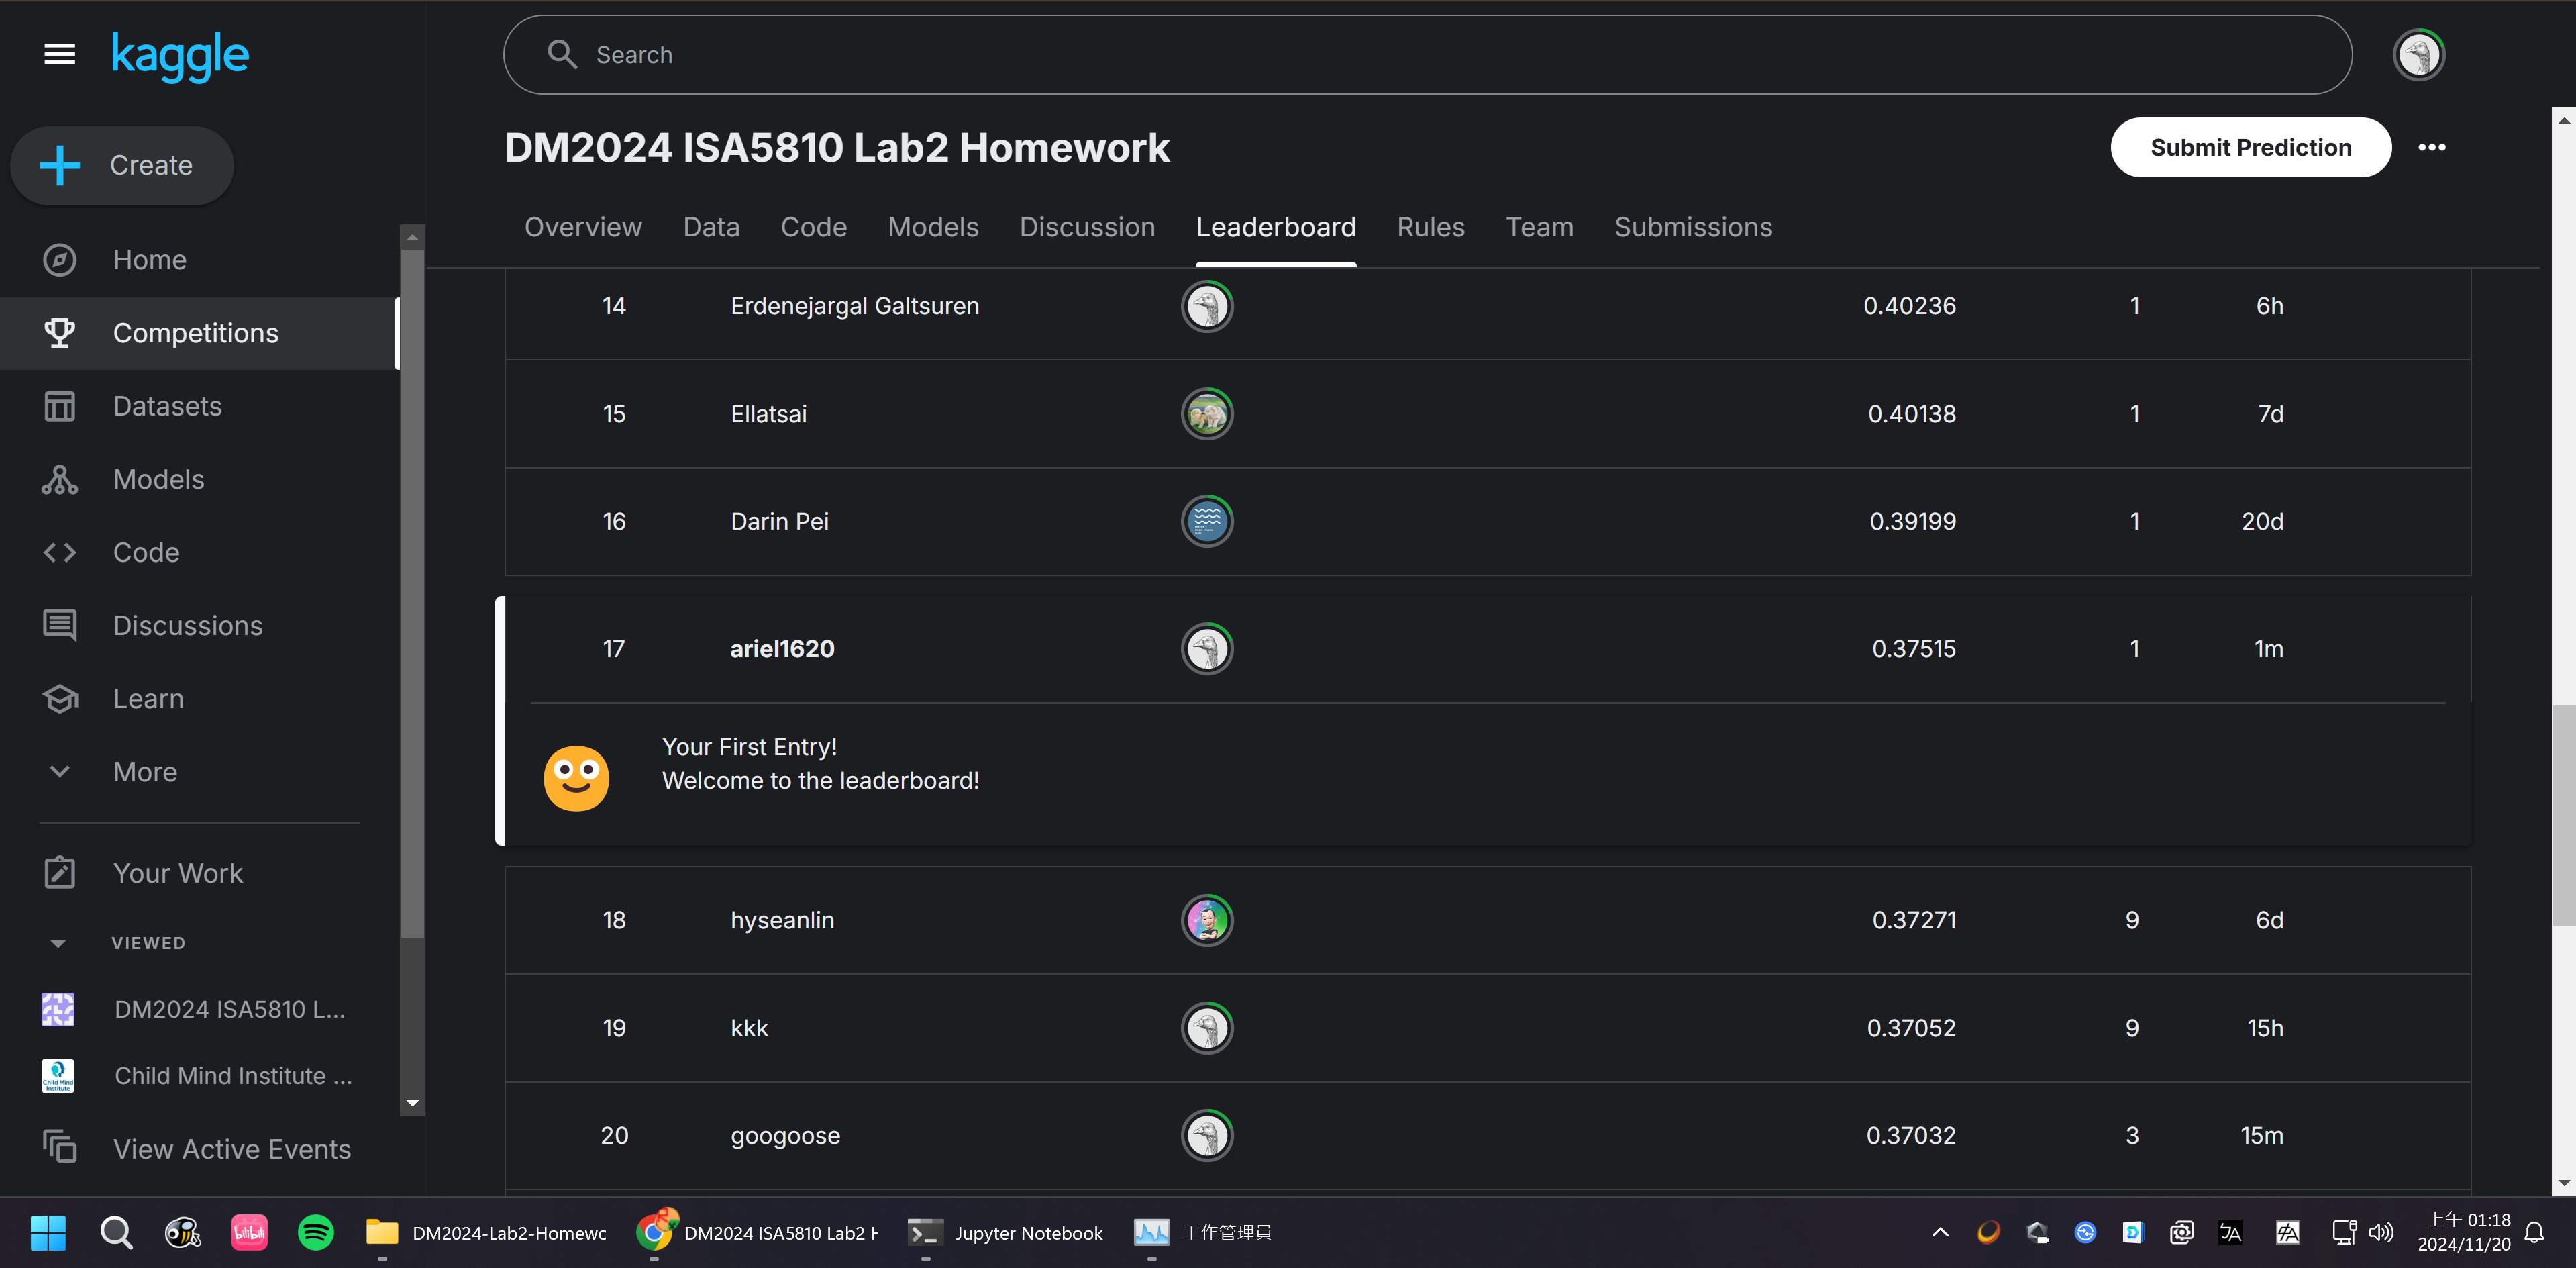

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

# 競賽

In [1]:
### Begin Assignment Here
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

---
## 讀取檔案

In [2]:
# 讀取 tweets_DM.json
tweets = []
with open('HW_compt/tweets_DM.json', 'r', encoding='utf-8') as file:
    for line in file:
        record = json.loads(line)
        tweet = record['_source']['tweet']
        tweets.append({
            'tweet_id': tweet['tweet_id'],
            'text': tweet['text']
        })
tweets_df = pd.DataFrame(tweets)

# 讀取 emotion.csv
emotion_df = pd.read_csv('HW_compt/emotion.csv', names=['tweet_id', 'emotion'])

# 讀取 data_identification.csv
data_id_df = pd.read_csv('HW_compt/data_identification.csv', names=['tweet_id', 'set'])

# 讀取 sampleSubmission.csv
submission_format = pd.read_csv('HW_compt/sampleSubmission.csv')

---
## 資料合併與清理

In [3]:
# 合併 tweets 和 data_identification
data = pd.merge(tweets_df, data_id_df, on='tweet_id', how='left')

# 再合併 emotion 資料，僅限訓練集有情緒標籤
data = pd.merge(data, emotion_df, on='tweet_id', how='left')

# 檢查資料結構
data.head()

,tweet_id,text,set,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x28b412,"Confident of your obedience, I write to you, k...",test,NaN
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN


In [4]:
# 檢查 tweet_id 的唯一性
print(f"tweets_DM.json 中的 tweet_id 唯一值數量: {tweets_df['tweet_id'].nunique()}")
print(f"emotion.csv 中的 tweet_id 唯一值數量: {emotion_df['tweet_id'].nunique()}")

# 檢查 emotion.csv 的 tweet_id 是否存在於 tweets_DM.json 中
missing_ids = emotion_df[~emotion_df['tweet_id'].isin(tweets_df['tweet_id'])]
print(f"emotion.csv 中無法匹配到的 tweet_id 數量: {len(missing_ids)}")

# 合併檢查
merged_data = pd.merge(tweets_df, emotion_df, on='tweet_id', how='left')
missing_labels = merged_data['emotion'].isnull().sum()
print(f"合併後缺失情緒標籤的推文數量: {missing_labels}")

tweets_DM.json 中的 tweet_id 唯一值數量: 1867535
emotion.csv 中的 tweet_id 唯一值數量: 1455564
emotion.csv 中無法匹配到的 tweet_id 數量: 1
合併後缺失情緒標籤的推文數量: 411972


---
## 數據清理

In [5]:
import re

# 清理推文文字
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # 移除網址
    text = re.sub(r'<LH>', '', text)  # 移除 <LH>
    text = re.sub(r'[^\w\s]', '', text)  # 移除標點符號
    return text.lower()  # 轉為小寫

data['cleaned_text'] = data['text'].apply(clean_text)

In [6]:
data

,tweet_id,text,set,emotion,cleaned_text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation,people who post add me on snapchat must be deh...
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness,brianklaas as we see trump is dangerous to fre...
2,0x28b412,"Confident of your obedience, I write to you, k...",test,NaN,confident of your obedience i write to you kno...
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear,now issa is stalking tasha
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN,trust is not the same as faith a friend is som...
...,...,...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,test,NaN,when you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,test,NaN,i swear all this hard work gone pay off one day
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,test,NaN,parcel2go no card left when i wasnt in so i ha...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",train,joy,ah corporate life where you can date using ju...


---
## Feature Engineering

In [7]:
# 將資料分為訓練與測試集
train_data = data[data['set'] == 'train']
test_data = data[data['set'] == 'test']

# 文本轉數值特徵
vectorizer = CountVectorizer(max_features=4000)
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
X_test = vectorizer.transform(test_data['cleaned_text'])

# 訓練集標籤
y_train = train_data['emotion']

---
## Model Training

In [8]:
# 訓練模型
model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=77)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=77)

---
## Predicting and Result

In [13]:
# 創建 test_data 副本
test_data_copy = test_data.copy()

# 測試集預測
test_data_copy['emotion'] = model.predict(X_test)

# 格式化提交結果
submission = test_data_copy[['tweet_id', 'emotion']].copy()

# 修改列名 tweet_id -> id
submission.rename(columns={'tweet_id': 'id'}, inplace=True)

# 輸出為 submission.csv
submission.to_csv('submission.csv', index=False)


---
# 作業 (Master Lab)